# RAW to RGB Conversion and Histogram Analysis

This notebook demonstrates how to read a `.raw` image file, convert it to a basic RGB format,
perform histogram normalization, and display the resulting image and its histogram.

# Import libraries

In [ ]:
%matplotlib widget # for interactive plots
import numpy as np
from pathlib import Path
from PIL import Image 
from skimage import exposure, util
import matplotlib.pyplot as plt
# there is a function for basic debyering with no interpolation and a function to do advanced debyering with interpolation
import colour
from colour_demosaicing import (
    demosaicing_CFA_Bayer_bilinear,
    demosaicing_CFA_Bayer_Malvar2004,
    demosaicing_CFA_Bayer_Menon2007)

DEMOSAICING_ALGORITHMS = {
        'bilinear': demosaicing_CFA_Bayer_bilinear,
        'malvar2004': demosaicing_CFA_Bayer_Malvar2004,
        'menon2007': demosaicing_CFA_Bayer_Menon2007,
    }

# Functions

In [8]:
def get_raw_paths(directory):
    """
    Gets paths to all raw files from a directory path as pathlib.Path objects.

    Args:
        directory (str or Path): The path to the directory.

    Returns:
        list: A list of pathlib.Path objects for the raw files found.
              Returns an empty list if the directory does not exist or no raw files are found.
    """
    extensions = [".raw"]
    raw_paths = []
    directory_path = Path(directory) # Ensure directory is a Path object

    if not directory_path.is_dir():
        print(f"Error: Directory not found at {directory}")
        return raw_paths

    try:
        # Use rglob to find files recursively with specified extensions
        for file_path in directory_path.rglob("*"):
            if file_path.is_file() and file_path.suffix.lower() in extensions:
                raw_paths.append(file_path) # Append the Path object

    except Exception as e:
        print(f"An error occurred while getting raw paths: {e}")

    return raw_paths

def raw_to_rgb_data_basic(raw_filepath, width, height):
    """
    Reads a .raw file, extracts color channels, and composes them into a basic RGB image array.

    Args:
        raw_filepath (str): The full path to the .raw file.
        width (int): The full horizontal size of the raw image data.
        height (int): The full vertical size of the raw image data.

    Returns:
        numpy.ndarray: A basic RGB image array with shape (height/2, width/2, 3),
                       or None if an error occurs.
    """
    full_width = width
    full_height = height
    expected_size = full_width * full_height * 1.5 # Assuming 12-bit data packed into 3 bytes for every 2 pixels

    try:
        # Read the raw file as uint8 bytes
        with open(raw_filepath, 'rb') as f:
            raw_data = np.fromfile(f, dtype=np.uint8)

        # Check if the file size matches the expected size
        if raw_data.size != expected_size:
             print(f"Warning: File size mismatch. Expected {expected_size} bytes, got {raw_data.size} bytes.")
             # Attempt to proceed, but be aware the data might be corrupted or format is different.
             # If the file is smaller than expected, truncate the data
             if raw_data.size < expected_size:
                 raw_data = raw_data[:expected_size]
                 print(f"Truncating raw data to {raw_data.size} bytes.")
             # If the file is larger, truncate to expected size
             elif raw_data.size > expected_size:
                 raw_data = raw_data[:expected_size]
                 print(f"Truncating raw data to {raw_data.size} bytes.")


        # Ensure raw_data size is a multiple of 3 for reshaping
        if raw_data.size % 3 != 0:
            print(f"Warning: Raw data size ({raw_data.size}) is not a multiple of 3 after size check. Truncating data.")
            raw_data = raw_data[:-(raw_data.size % 3)]


        # Reconstruct 12-bit values from 3 bytes (a, b, c) based on the MATLAB logic
        outval = np.zeros(full_width * full_height, dtype=np.uint16)

        # First values: out(1:3:end) + bitshift(bitand(out(2:3:end),15),8)
        # Python indexing: raw_data[0::3] + (raw_data[1::3] & 15) << 8
        outval[0::2] = raw_data[0::3].astype(np.uint16) + (np.bitwise_and(raw_data[1::3], 15).astype(np.uint16) << 8)

        # Second values: bitshift(out(3:3:end),4) + bitshift(bitand(out(2:3:end),240),-4)
        # Python indexing: (raw_data[2::3] << 4) + (np.bitwise_and(raw_data[1::3], 240).astype(np.uint16) >> 4)
        outval[1::2] = (raw_data[2::3].astype(np.uint16) << 4) + (np.bitwise_and(raw_data[1::3], 240).astype(np.uint16) >> 4)


        # Reshape the 12-bit values into the full image dimensions
        out_reshaped = outval.reshape((full_height, full_width))

        # Extract the four color channels based on the Bayer pattern
        # Assuming a RGGB or similar pattern where:
        # c1 = Top-Left (e.g., Red)
        # c2 = Top-Right (e.g., Green)
        # c3 = Bottom-Left (e.g., Green)
        # c4 = Bottom-Right (e.g., Blue)
        c1 = out_reshaped[0::2, 0::2] # Rows 0, 2, 4... and Columns 0, 2, 4...
        c2 = out_reshaped[0::2, 1::2] # Rows 0, 2, 4... and Columns 1, 3, 5...
        c3 = out_reshaped[1::2, 0::2] # Rows 1, 3, 5... and Columns 0, 2, 4...
        c4 = out_reshaped[1::2, 1::2] # Rows 1, 3, 5... and Columns 1, 3, 5...

        # Combine channels into a basic RGB image (simple averaging for green)
        # This is a simplified approach and not a full demosaicing algorithm.
        # The resulting image will have dimensions (height/2, width/2, 3)
        rgb_image_basic = np.zeros((height // 2, width // 2, 3), dtype=np.uint16)
        rgb_image_basic[:,:,0] = c1 # Red?
        rgb_image_basic[:,:,1] = (c2 + c3) // 2 # Green? (averaged)
        rgb_image_basic[:,:,2] = c4 # Blue?

        return rgb_image_basic

    except FileNotFoundError:
        print(f"Error: File not found at {raw_filepath}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def raw_to_rgb_data(raw_filepath, width, height, target_bayer_pattern='RGGB', algorithm_name='bilinear'):
    """
    Reads a .raw file, unpacks 12-bit data, performs full demosaicing using colour-demosaicing,
    and returns a full-size RGB image array.

    Args:
        raw_filepath (str or Path): The full path to the .raw file.
        width (int): The full horizontal size of the raw image data.
        height (int): The full vertical size of the raw image data.
        target_bayer_pattern (str): The Bayer pattern, e.g., 'RGGB', 'GRBG', 'GBRG', 'BGGR'.
        algorithm_name (str): Name of the demosaicing algorithm to use.

    Returns:
        numpy.ndarray: A full-size RGB image array (height, width, 3) of dtype uint16 (0-4095)
                       or None if an error occurs.
    """
    full_width = width
    full_height = height
    # Each 12-bit pixel uses 1.5 bytes on average (2 pixels = 24 bits = 3 bytes)
    expected_size = int(full_width * full_height * 1.5)
        
    demosaic_func = DEMOSAICING_ALGORITHMS.get(algorithm_name.lower())
    if not demosaic_func:
        print(f"Error: Demosaicing algorithm '{algorithm_name}' not found or supported. Available: {list(DEMOSAICING_ALGORITHMS.keys())}")
        return Nonegb

    try:
        with open(Path(raw_filepath), 'rb') as f:
            raw_data = np.fromfile(f, dtype=np.uint8)

        if raw_data.size != expected_size:
             print(f"Warning: File size mismatch for {raw_filepath.name}. Expected {expected_size} bytes, got {raw_data.size} bytes.")
             if raw_data.size < expected_size:
                 print(f"Error: File {raw_filepath.name} is smaller than expected. Cannot reliably process. Skipping.")
                 return None
             elif raw_data.size > expected_size:
                 print(f"Warning: File {raw_filepath.name} is larger than expected. Truncating raw data to {expected_size} bytes.")
                 raw_data = raw_data[:expected_size]

        if raw_data.size % 3 != 0:
            print(f"Warning: Raw data size ({raw_data.size}) for {raw_filepath.name} is not a multiple of 3. Truncating.")
            raw_data = raw_data[:-(raw_data.size % 3)]
            if raw_data.size == 0:
                print(f"Error: Raw data size became 0 for {raw_filepath.name} after truncation. Skipping.")
                return None

        num_pixels = (raw_data.size // 3) * 2
        outval = np.zeros(num_pixels, dtype=np.uint16) # Unpacked data will be 0-4095

        byte1 = raw_data[0::3].astype(np.uint16)
        byte2 = raw_data[1::3].astype(np.uint16)
        byte3 = raw_data[2::3].astype(np.uint16)
        
        min_len = min(len(byte1), len(byte2), len(byte3))
        byte1 = byte1[:min_len]
        byte2 = byte2[:min_len]
        byte3 = byte3[:min_len]

        outval[0:min_len*2:2] = byte1 + (np.bitwise_and(byte2, 0x0F) << 8)
        outval[1:min_len*2:2] = (byte3 << 4) + (np.bitwise_and(byte2, 0xF0) >> 4)
        
        if outval.size > full_width * full_height:
            outval = outval[:full_width * full_height]
        elif outval.size < full_width * full_height:
             print(f"Error: Decoded pixel count ({outval.size}) is less than expected ({full_width * full_height}) for {raw_filepath.name} after unpacking. Skipping.")
             return None

        cfa_bayer_data_uint16 = outval.reshape((full_height, full_width)) # This is our Bayer pattern array, uint16, range 0-4095
        
        # Perform Demosaicing using colour-demosaicing library
        # The library functions typically expect float input [0,1] or integer input.
        # If integer, they scale it based on dtype. For uint16, max is 65535.
        # Our data is 12-bit (max 4095) stored in uint16.
        # To ensure correct scaling by the library if it assumes full uint16 range,
        # it's safer to convert to float and normalize to [0,1] based on 12-bit depth.
        
        cfa_bayer_data_float = cfa_bayer_data_uint16.astype(np.float32) / 4095.0
        cfa_bayer_data_float = np.clip(cfa_bayer_data_float, 0, 1) # Ensure it's strictly [0,1]

        print(f"Demosaicing with '{algorithm_name}' and pattern '{target_bayer_pattern}'...")
        rgb_image_float_0_1 = demosaic_func(cfa_bayer_data_float, pattern=target_bayer_pattern)
        # Output of demosaic_func is float, typically in range [0, 1]

        # Scale back to 0-4095 range for 12-bit depth
        rgb_image_scaled_float = rgb_image_float_0_1 * 4095.0
        
        # Clip to ensure values are within the valid 12-bit range and convert to uint16
        rgb_image_final_uint16 = np.clip(rgb_image_scaled_float, 0, 4095).astype(np.uint16)

        return rgb_image_final_uint16

    except FileNotFoundError:
        print(f"Error: File not found at {raw_filepath}")
        return None
    except Exception as e:
        print(f"An error occurred while processing {raw_filepath.name}: {e}")
        import traceback
        traceback.print_exc()
        return None

def normalize(arr):
    """Takes a numpy array and normalizes and re-scales min max intensity 0-1,
    also scales it 0-255 and returns both versions"""
    
    #Eqalize and Normalize the array to the range 0-1
    arr_min = arr.min()
    arr_max = arr.max()
    normalized_arr = (arr - arr_min) / (arr_max - arr_min)
    
    # Scale to the range 0-255
    scaled_arr = (normalized_arr * 255).astype(np.uint8)
    
    return normalized_arr,scaled_arr



# read in image and anylisis

In [9]:
#this reads a folder and gets a list of raw files, then prints the path to one of them

#raw_files = get_raw_paths('kinston_test') # Pass string path to the function
#raw_files = get_raw_paths('20241003_image')
raw_files = get_raw_paths('20240905_image')
print(raw_files[6])

20240905_image/gps_data_000159_ChainDigger729_fl9mm-20240905_141821_860.raw


In [10]:
#this cell does a basic raw to rgb debyer, it does not interpolate so the image is halved in size.
#outputs two files one scaled 0-1 and one scaled 0-255

image_width = 1440  # CHANGE THIS TO YOUR IMAGE WIDTH
image_height = 1080 # CHANGE THIS TO YOUR IMAGE HEIGHT

im_array_basic= raw_to_rgb_data_basic(raw_files[6], image_width, image_height)

array01b,array255b=normalize(im_array_basic)

In [11]:
#this cell does a full rq to rgb debayer with interpolation

image_width = 1440  # CHANGE THIS TO YOUR IMAGE WIDTH
image_height = 1080 # CHANGE THIS TO YOUR IMAGE HEIGHT

im_array_interp= raw_to_rgb_data(raw_files[6], image_width, image_height)

array01,array255=normalize(im_array_interp)

Demosaicing with 'bilinear' and pattern 'RGGB'...


In [12]:
#here you can check file statistics, see that its rgb and this size data type and max min
check_array=array255

print(type(check_array))
print(check_array.dtype)
print(check_array.size)
print(check_array.ndim)
print(check_array.shape)
print(check_array.max())
print(check_array.min())

<class 'numpy.ndarray'>
uint8
4665600
3
(1080, 1440, 3)
255
0


In [13]:
check_array=array01

print(type(check_array))
print(check_array.dtype)
print(check_array.size)
print(check_array.ndim)
print(check_array.shape)
print(check_array.max())
print(check_array.min())

<class 'numpy.ndarray'>
float64
4665600
3
(1080, 1440, 3)
1.0
0.0


In [24]:
rescale=exposure.rescale_intensity(array01b)

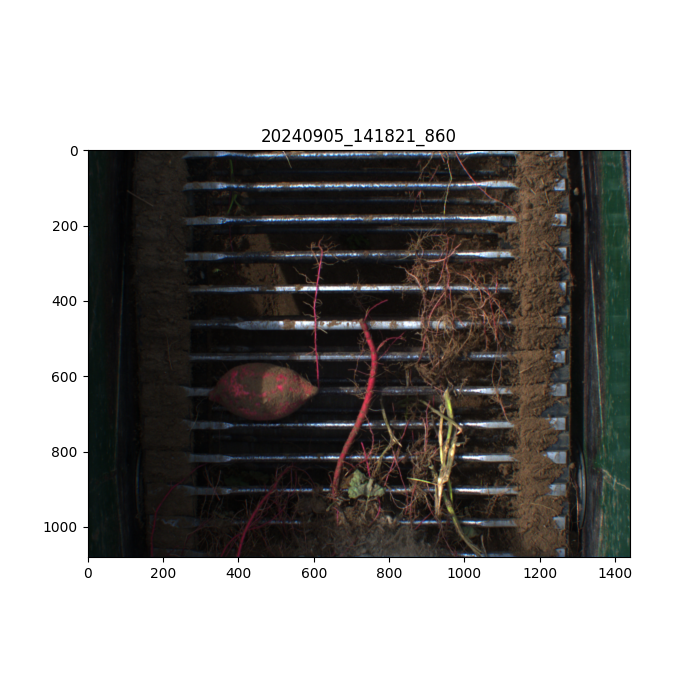

In [14]:
# Create a figure and an axes for the plot
fig, ax = plt.subplots(figsize=(7, 7))
# Display the image
im = ax.imshow(array255)

# Add a colorbar to show the mapping of pixel values to colors
#plt.colorbar(im, ax=ax, label="Pixel Intensity")

# Set title and labels
ax.set_title("20240905_141821_860")
#ax.set_xlabel("X-coordinate (Width)")
#ax.set_ylabel("Y-coordinate (Height)")

# Ensure the aspect ratio is equal so pixels appear square
ax.set_aspect('equal')

# Display the plot
# With %matplotlib widget, plt.show() is often not strictly necessary
# but it's good practice.
plt.show()

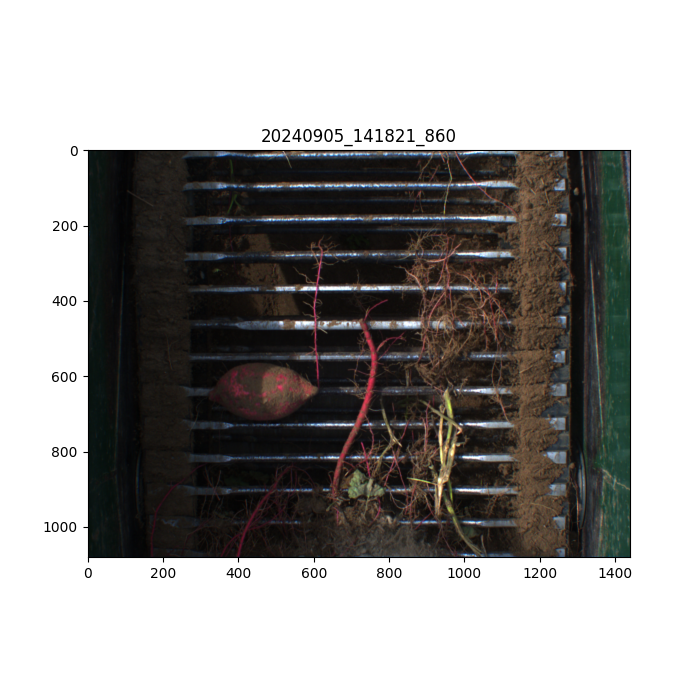

In [15]:
# Create a figure and an axes for the plot
fig, ax = plt.subplots(figsize=(7, 7))
# Display the image
im = ax.imshow(array01)

# Add a colorbar to show the mapping of pixel values to colors
#plt.colorbar(im, ax=ax, label="Pixel Intensity")

# Set title and labels
ax.set_title("20240905_141821_860")
#ax.set_xlabel("X-coordinate (Width)")
#ax.set_ylabel("Y-coordinate (Height)")

# Ensure the aspect ratio is equal so pixels appear square
ax.set_aspect('equal')

# Display the plot
# With %matplotlib widget, plt.show() is often not strictly necessary
# but it's good practice.
plt.show()

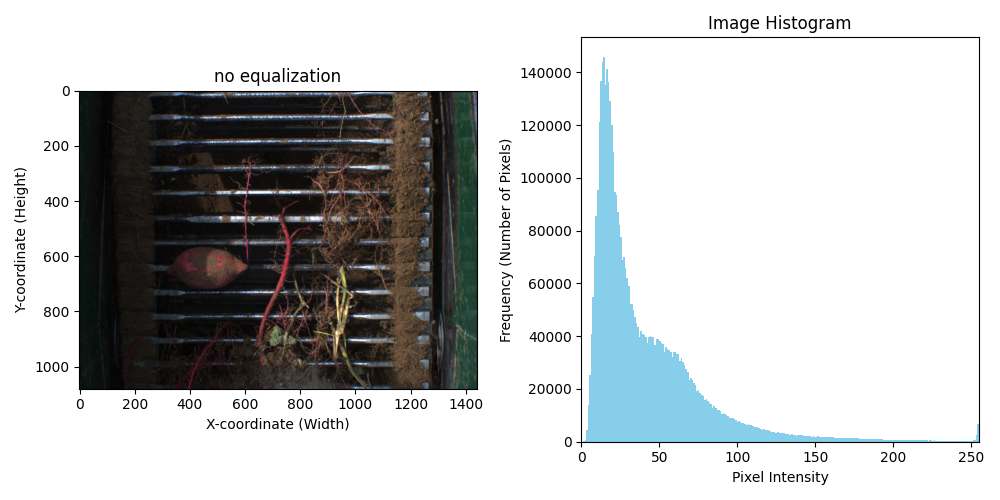

In [16]:
iimage=array255

# Create a figure with two subplots side-by-side
# (1 row, 2 columns), with a larger figure size for better visibility
fig, (ax_img, ax_hist) = plt.subplots(1, 2, figsize=(10, 5))

# --- Image Display Subplot ---
# Display the image on the first subplot (ax_img)
# For grayscale, 'cmap' is important. 'gray' or 'viridis' are common.
# For RGB, just pass the 3D array.
im = ax_img.imshow(iimage)
# Add a colorbar to show the mapping of pixel values to colors
#plt.colorbar(im, ax=ax_img, label="Pixel Intensity")

# Set title and labels for the image subplot
ax_img.set_title("no equalization")
ax_img.set_xlabel("X-coordinate (Width)")
ax_img.set_ylabel("Y-coordinate (Height)")

# Ensure the aspect ratio is equal so pixels appear square
ax_img.set_aspect('equal')

# --- Histogram Subplot ---
# Flatten the image data to 1D for histogram calculation
# Use 256 bins for a uint8 image (0-255)
ax_hist.hist(iimage.flatten(), bins=256, color='skyblue')

# Set title and labels for the histogram subplot
ax_hist.set_title("Image Histogram")
ax_hist.set_xlabel("Pixel Intensity")
ax_hist.set_ylabel("Frequency (Number of Pixels)")
ax_hist.set_xlim(0,255)
#ax_hist.set_ylim(0,100)

#

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
# With %matplotlib widget, plt.show() is often not strictly necessary
# but it's good practice.
plt.show()

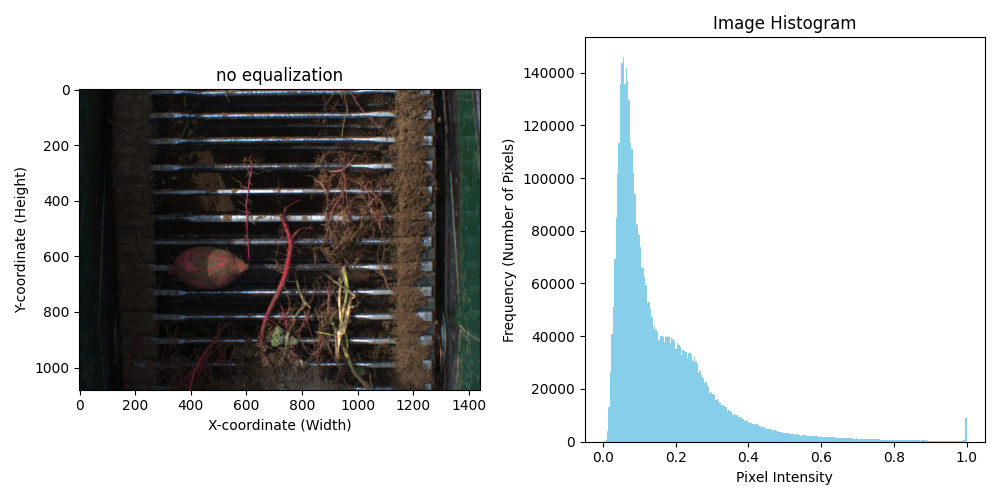

In [25]:
iimage=array01

# Create a figure with two subplots side-by-side
# (1 row, 2 columns), with a larger figure size for better visibility
fig, (ax_img, ax_hist) = plt.subplots(1, 2, figsize=(10, 5))

# --- Image Display Subplot ---
# Display the image on the first subplot (ax_img)
# For grayscale, 'cmap' is important. 'gray' or 'viridis' are common.
# For RGB, just pass the 3D array.
im = ax_img.imshow(iimage)
# Add a colorbar to show the mapping of pixel values to colors
#plt.colorbar(im, ax=ax_img, label="Pixel Intensity")

# Set title and labels for the image subplot
ax_img.set_title("no equalization")
ax_img.set_xlabel("X-coordinate (Width)")
ax_img.set_ylabel("Y-coordinate (Height)")

# Ensure the aspect ratio is equal so pixels appear square
ax_img.set_aspect('equal')

# --- Histogram Subplot ---
# Flatten the image data to 1D for histogram calculation
# Use 256 bins for a uint8 image (0-255)
ax_hist.hist(iimage.flatten(), bins=256, color='skyblue')

# Set title and labels for the histogram subplot
ax_hist.set_title("Image Histogram")
ax_hist.set_xlabel("Pixel Intensity")
ax_hist.set_ylabel("Frequency (Number of Pixels)")
#ax_hist.set_xlim(0,1)
#ax_hist.set_ylim(0,100)

#

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
# With %matplotlib widget, plt.show() is often not strictly necessary
# but it's good practice.
plt.show()

In [18]:
#process image whith adaptive equaliztion
equalized = exposure.equalize_adapthist(array255b,clip_limit=0.03)


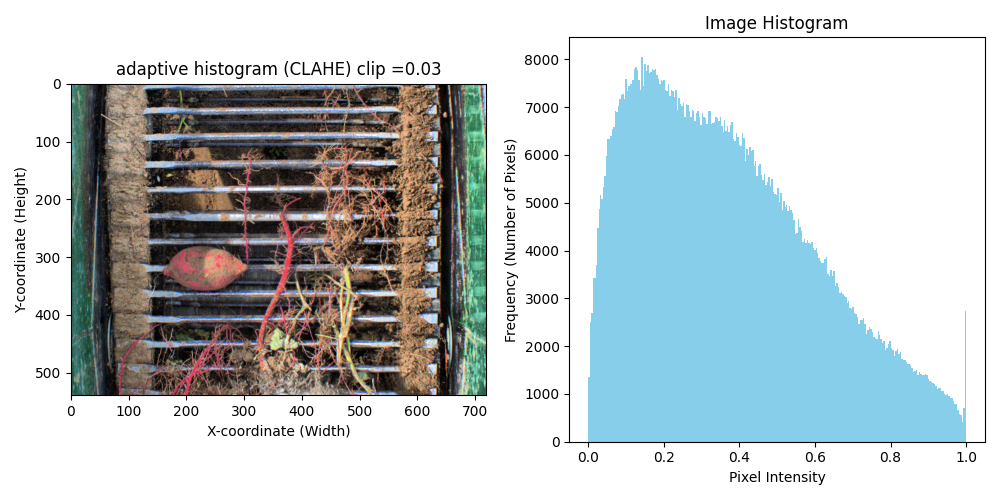

In [19]:
iimage=equalized

# Create a figure with two subplots side-by-side
# (1 row, 2 columns), with a larger figure size for better visibility
fig, (ax_img, ax_hist) = plt.subplots(1, 2, figsize=(10, 5))

# --- Image Display Subplot ---
# Display the image on the first subplot (ax_img)
# For grayscale, 'cmap' is important. 'gray' or 'viridis' are common.
# For RGB, just pass the 3D array.
im = ax_img.imshow(iimage)
# Add a colorbar to show the mapping of pixel values to colors
#plt.colorbar(im, ax=ax_img, label="Pixel Intensity")

# Set title and labels for the image subplot
ax_img.set_title("adaptive histogram (CLAHE) clip =0.03")
ax_img.set_xlabel("X-coordinate (Width)")
ax_img.set_ylabel("Y-coordinate (Height)")

# Ensure the aspect ratio is equal so pixels appear square
ax_img.set_aspect('equal')

# --- Histogram Subplot ---
# Flatten the image data to 1D for histogram calculation
ax_hist.hist(iimage.flatten(), bins=256, color='skyblue')

# Set title and labels for the histogram subplot
ax_hist.set_title("Image Histogram")
ax_hist.set_xlabel("Pixel Intensity")
ax_hist.set_ylabel("Frequency (Number of Pixels)")
#ax_hist.set_xlim(0,255)
#ax_hist.set_ylim(0,100)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
# With %matplotlib widget, plt.show() is often not strictly necessary
# but it's good practice.
plt.show()